In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import os

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# load data

In [11]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_)

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

dataset_path = "data_msg_type/"
X_path = dataset_path + "x.txt"
y_path = dataset_path + "y.txt"

X = load_X(X_path)
y = load_y(y_path)
x = X.reshape(len(X), 1, 7, 2)

# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_y.shape)

Separating data into 80% training set & 20% test set...
Dataset separated.

((160000, 1, 7, 2), (160000, 14), (40000, 14))


# define parameters

In [4]:
input_height = 1
input_width = 7
num_channels = 2
num_labels = 14  

batch_size = 128
kernel_size = 3
depth = 20
num_hidden = 1000

learning_rate = 0.001
# iteration times
training_epochs = 100

total_batches = train_x.shape[0] // batch_size

# network config

In [5]:
# init nn parameters
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

# conv
def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

# build network

In [6]:
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,1,1)
c = apply_depthwise_conv(p,3,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

# loss func
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_history = np.empty(shape=[1], dtype=float)

# train and test

In [7]:
with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        for b in range(total_batches):    
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print "Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ", \
          session.run(accuracy, feed_dict={X: train_x, Y: train_y})
    y_pred = tf.argmax(y_, 1)
    y_true = np.argmax(test_y, 1)
    final_acc, y_pred = session.run([accuracy, y_pred], feed_dict={X: test_x, Y: test_y})
    print "Testing Accuracy: {}".format(final_acc)
    print()
    
    # model metrics
    temp_y_true = np.unique(y_true)
    temp_y_pred = np.unique(y_pred) 
    np.save("data/y_true", y_true) 
    np.save("data/y_pred", y_pred) 
    print "temp_y_true", temp_y_true 
    print "temp_y_pred", temp_y_pred
    
    print(classification_report(y_true, y_pred, 
                                target_names = fault_label.values()))
    print("confusion_matrix: ")
    print confusion_matrix(y_true, y_pred)

Epoch:  0  Training Loss:  0.169573  Training Accuracy:  0.998468
Epoch:  1  Training Loss:  0.0655929  Training Accuracy:  0.99883
Epoch:  2  Training Loss:  0.0422432  Training Accuracy:  0.999049
Epoch:  3  Training Loss:  0.0301881  Training Accuracy:  0.999699
Epoch:  4  Training Loss:  0.0227108  Training Accuracy:  0.999805
Epoch:  5  Training Loss:  0.017843  Training Accuracy:  0.99983
Epoch:  6  Training Loss:  0.0145738  Training Accuracy:  0.999861
Epoch:  7  Training Loss:  0.012415  Training Accuracy:  0.999861
Epoch:  8  Training Loss:  0.0108439  Training Accuracy:  0.999911
Epoch:  9  Training Loss:  0.00970526  Training Accuracy:  0.999911
Epoch:  10  Training Loss:  0.00887846  Training Accuracy:  0.999924
Epoch:  11  Training Loss:  0.00820043  Training Accuracy:  0.999924
Epoch:  12  Training Loss:  0.00756564  Training Accuracy:  0.999924
Epoch:  13  Training Loss:  0.00687725  Training Accuracy:  0.999923
Epoch:  14  Training Loss:  0.00623022  Training Accuracy:

NameError: name 'fault_label' is not defined

# confusion matrix

               precision    recall  f1-score   support

     security       1.00      1.00      1.00       279
       others       1.00      1.00      1.00      1475
    processor       1.00      1.00      1.00      5774
         disk       1.00      1.00      1.00        16
      network       1.00      1.00      1.00       248
         file       1.00      1.00      1.00     29818
     database       1.00      1.00      1.00        64
      service       1.00      1.00      1.00       479
       memory       1.00      1.00      1.00       207
communication       1.00      1.00      1.00       383
       system       1.00      1.00      1.00        34
       driver       1.00      1.00      1.00      1102
           io       1.00      1.00      1.00       121

  avg / total       1.00      1.00      1.00     40000

[[  279     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0  1475     0     0     0     0     0     0     0     0     0     0
      0]
 [    

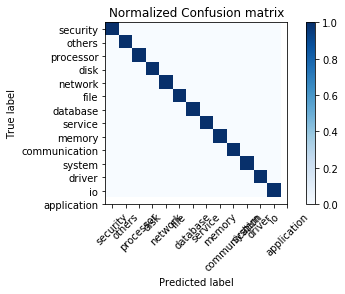

In [12]:
def plot_confusion_matrix(cm, title='Normalized Confusion matrix', 
                          cmap=plt.cm.get_cmap("Blues")): 
    cm = cm / cm.astype(np.float).sum(axis=1) 
    #print "confusion_matrix: \n{}".format(cm) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title) 
    plt.colorbar() 
    tick_marks =np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=45) 
    plt.yticks(tick_marks, fault_label.values()) 
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 
    plt.show()

def test_(): 
    y_true = np.load("data/y_true.npy") 
    y_pred = np.load("data/y_pred.npy") 
    print(classification_report(y_true, y_pred, 
          target_names = fault_label.values()))
    print(confusion_matrix(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred))

if __name__ == "__main__":
    test_()